In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

sys.path.append("..")
from MLP_utils.utils import parameter_set
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)


sys.path.append("../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()

In [3]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)
params.MODEL_TYPE

'Multi_Class'

In [4]:
def test_loop(df, output_name, title):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", params.IN_FEATURES)
    if params.MODEL_TYPE == "Regression":
        params.OUT_FEATURES = 1
    else:
        params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", params.OUT_FEATURES)

    if params.OUT_FEATURES > 2:
        params.MODEL_TYPE = "Multi_Class"
    elif params.OUT_FEATURES == 2:
        params.OUT_FEATURES = params.OUT_FEATURES - 1
        params.MODEL_TYPE = "Binary_Classification"
    elif params.OUT_FEATURES == 1:
        params.MODEL_TYPE = "Regression"
    else:
        pass
    print(params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(params, params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputing list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            params,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [5]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['media ctr_0_Media ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'DMSO_0.100_Z-VAD-FMK_100.0', 'DMSO_0.100_Z-VAD-FMK_30.0',
       'DMSO_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'Topotecan_5.000_DMSO_0.025',
       'Topotecan_10.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_0.1', 'LPS_10.000_Disulfiram_1.0',
       'LPS_10.000_Disulfiram_2.5',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.500_DMSO_0.025', 'H2O2_100.000_DMSO_0.025',
       'LPS_10.000_Z-VAD-FMK_100.0', 'LPS_100.000_DMSO_0.025',
       'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'LPS_Nigericin_1.000_3.0_DMSO_0.025',
       'LPS_Nigericin_1.000_1

In [6]:
paired_treatment_list = [
    ["LPS_100.000_DMSO_0.025", "H2O2_100.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "Thapsigargin_1.000_DMSO_0.025",
        "H2O2_100.000_Z-VAD-FMK_100.0",
        "DMSO_0.100_DMSO_0.025",
    ],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_10.000_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "LPS_100.000_DMSO_0.025",
        "Thapsigargin_1.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
    ["LPS_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    ["LPS_1.000_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025", "DMSO_0.100_DMSO_0.025"],
    [
        "LPS_10.000_DMSO_0.025",
        "Thapsigargin_10.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
    [
        "LPS_100.000_DMSO_0.025",
        "Thapsigargin_10.000_DMSO_0.025",
        "DMSO_0.100_DMSO_0.025",
    ],
]

DMSO_0.100_DMSO_0.025 H2O2_100.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.60      0.85      0.70     35643
           1       0.15      0.13      0.14     26900
           2       0.00      0.00      0.00     15987

    accuracy                           0.43     78530
   macro avg       0.25      0.33      0.28     78530
weighted avg       0.33      0.43      0.37     78530

Precision for class 0: 0.6005156683855613
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.15383567862006356
Recall for class 1: 0.12598513011152415
Precision for class 2: 0.0024671052631578946
Recall for class 2: 0.0009382623381497466
3


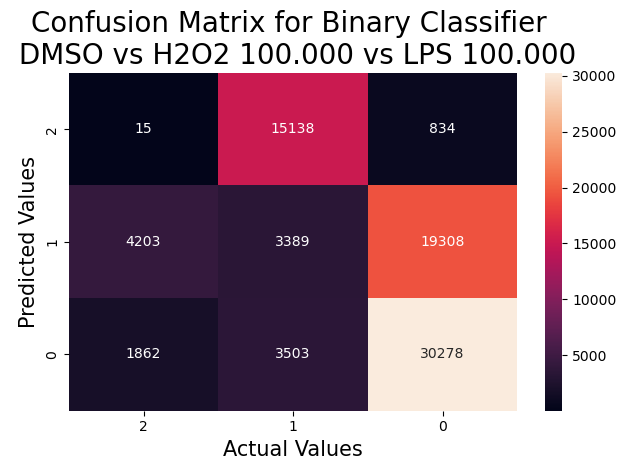

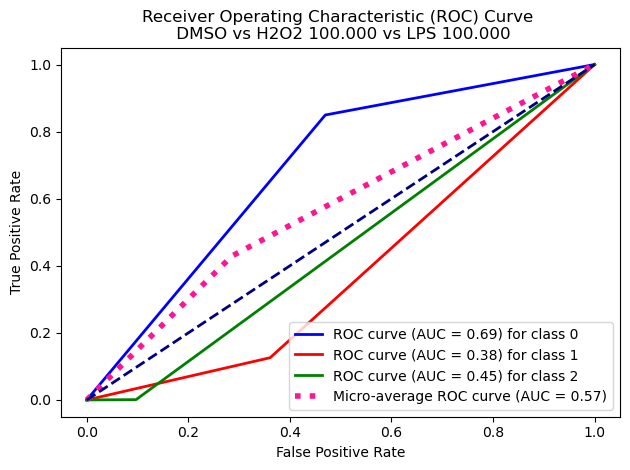

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 H2O2_100.000_Z-VAD-FMK_100.0
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.66      0.85      0.74     35643
           1       0.17      0.06      0.09     14747
           2       0.58      0.56      0.57     13766

    accuracy                           0.61     64156
   macro avg       0.47      0.49      0.47     64156
weighted avg       0.53      0.61      0.56     64156

Precision for class 0: 0.6624513193016234
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.17483044461190655
Recall for class 1: 0.06292805316335526
Precision for class 2: 0.5847663978085528
Recall for class 2: 0.5582594798779602
3


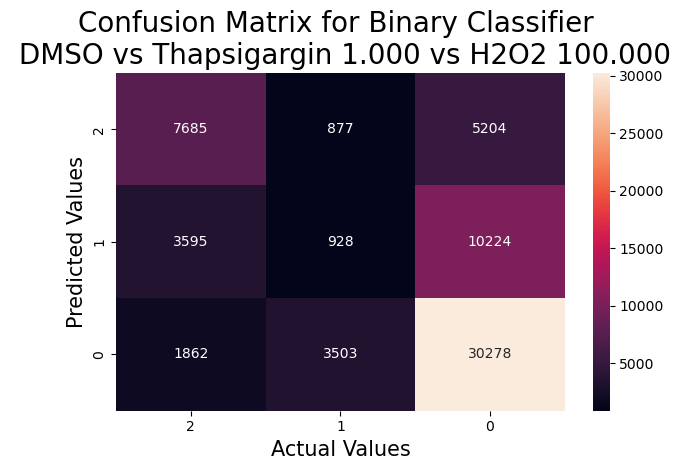

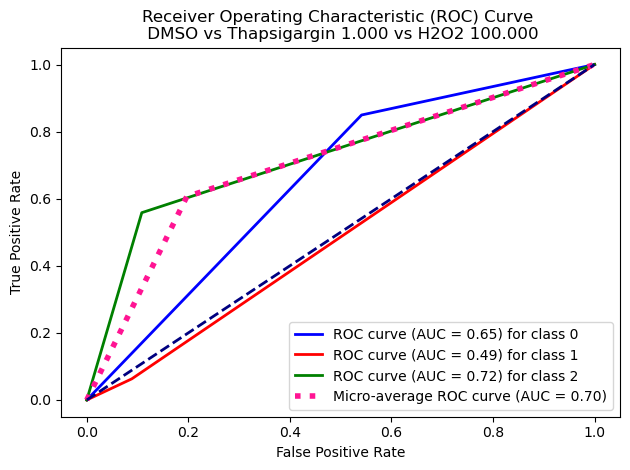

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     35643
           1       0.38      0.16      0.22     17510
           2       0.73      0.56      0.63     13766

    accuracy                           0.61     66919
   macro avg       0.58      0.52      0.52     66919
weighted avg       0.58      0.61      0.57     66919

Precision for class 0: 0.6144324039124964
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.3841394825646794
Recall for class 1: 0.15602512849800115
Precision for class 2: 0.7298888783360243
Recall for class 2: 0.5582594798779602
3


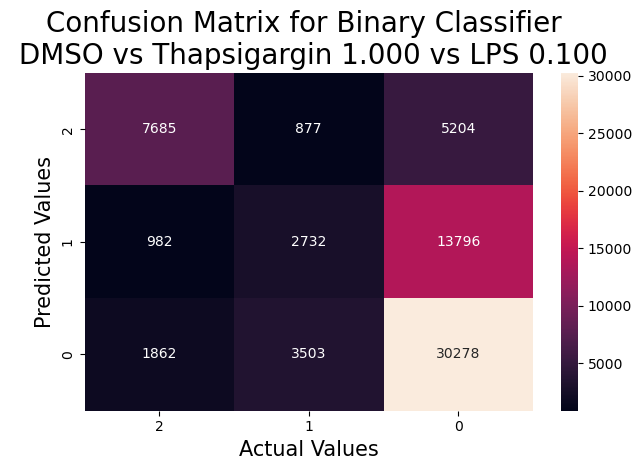

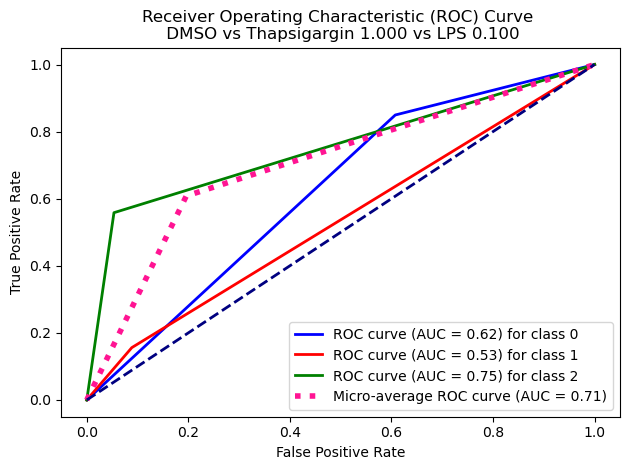

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.63      0.85      0.72     35643
           1       0.36      0.15      0.21     16458
           2       0.70      0.56      0.62     13766

    accuracy                           0.61     65867
   macro avg       0.56      0.52      0.52     65867
weighted avg       0.58      0.61      0.57     65867

Precision for class 0: 0.6306996896285958
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.3564501910079342
Recall for class 1: 0.1474055170737635
Precision for class 2: 0.6952234485254206
Recall for class 2: 0.5582594798779602
3


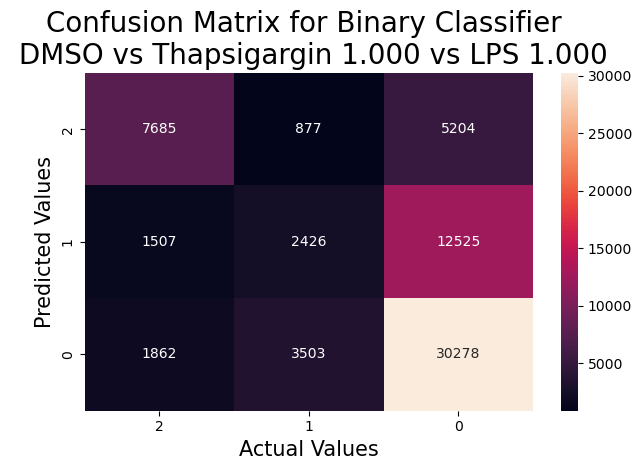

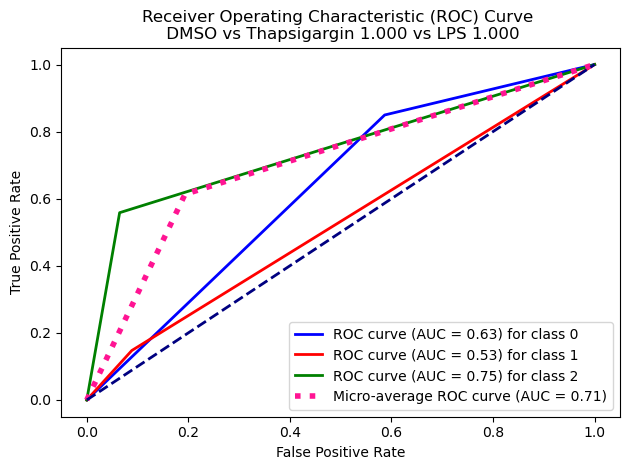

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.63      0.85      0.72     35643
           1       0.40      0.18      0.24     16810
           2       0.70      0.56      0.62     13766

    accuracy                           0.62     66219
   macro avg       0.58      0.53      0.53     66219
weighted avg       0.59      0.62      0.58     66219

Precision for class 0: 0.6314889356998352
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.40302575984734906
Recall for class 1: 0.1759071980963712
Precision for class 2: 0.7027892089620486
Recall for class 2: 0.5582594798779602
3


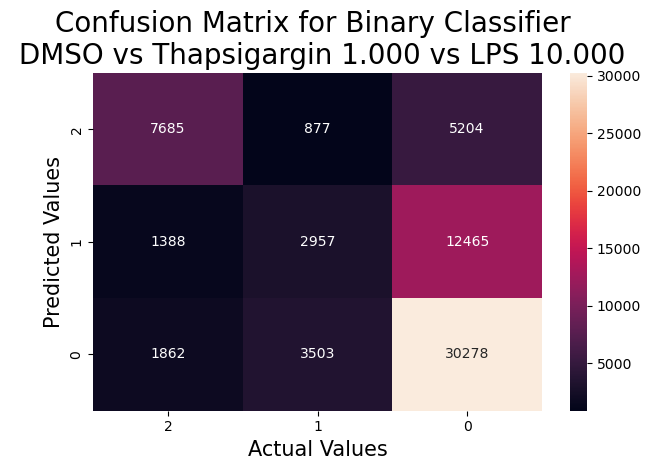

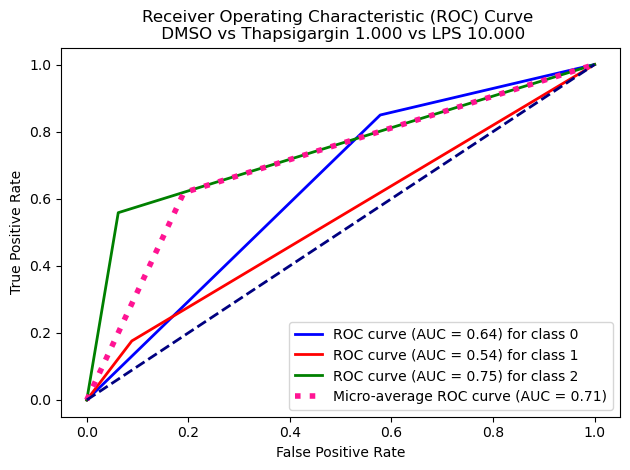

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     35643
           1       0.78      0.95      0.85     15987
           2       0.80      0.56      0.66     13766

    accuracy                           0.81     65396
   macro avg       0.80      0.78      0.78     65396
weighted avg       0.81      0.81      0.81     65396

Precision for class 0: 0.8337371957264016
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.7755917614509683
Recall for class 1: 0.9468943516607243
Precision for class 2: 0.8037021543610123
Recall for class 2: 0.5582594798779602
3


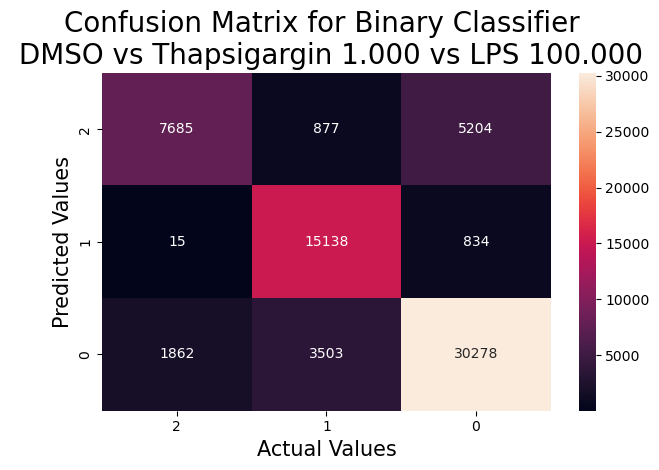

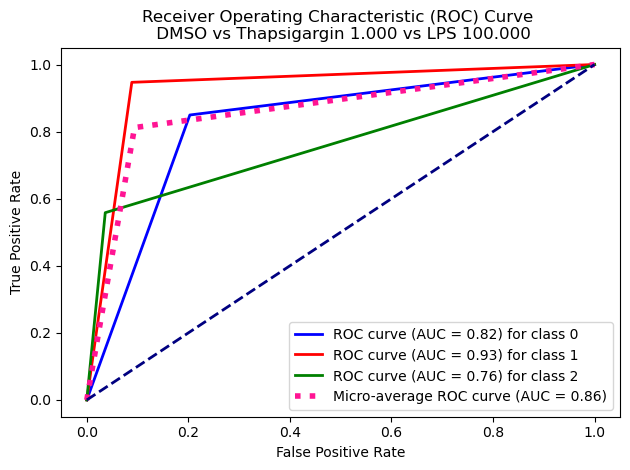

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.66      0.85      0.74     35643
           1       0.41      0.16      0.23     17510
           2       0.80      0.84      0.82     13212

    accuracy                           0.66     66365
   macro avg       0.62      0.62      0.60     66365
weighted avg       0.62      0.66      0.62     66365

Precision for class 0: 0.6621326102169349
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.4079438554576676
Recall for class 1: 0.15602512849800115
Precision for class 2: 0.7959827833572455
Recall for class 2: 0.8398425673630033
3


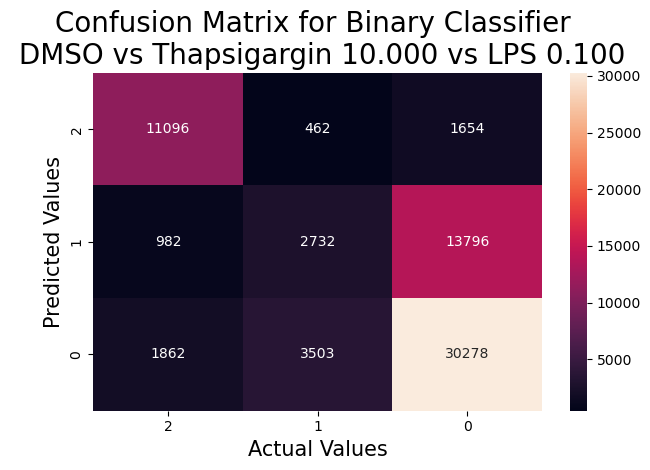

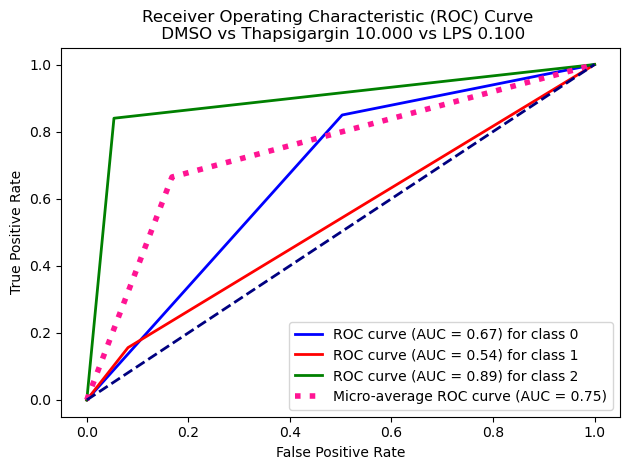

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.68      0.85      0.76     35643
           1       0.38      0.15      0.21     16458
           2       0.77      0.84      0.80     13212

    accuracy                           0.67     65313
   macro avg       0.61      0.61      0.59     65313
weighted avg       0.62      0.67      0.63     65313

Precision for class 0: 0.6810625998155521
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.37959630730715066
Recall for class 1: 0.1474055170737635
Precision for class 2: 0.7670929830625648
Recall for class 2: 0.8398425673630033
3


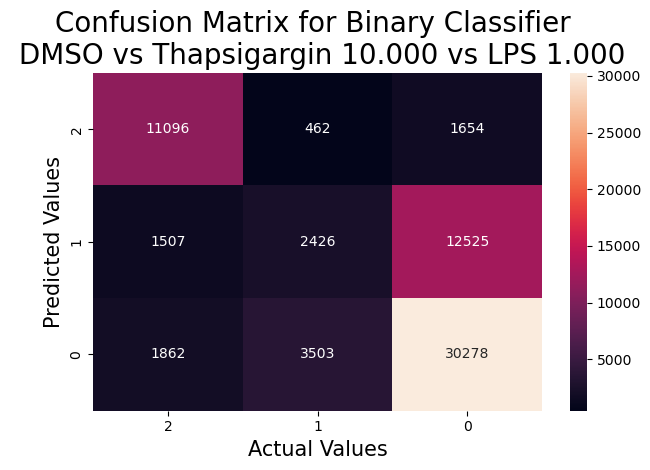

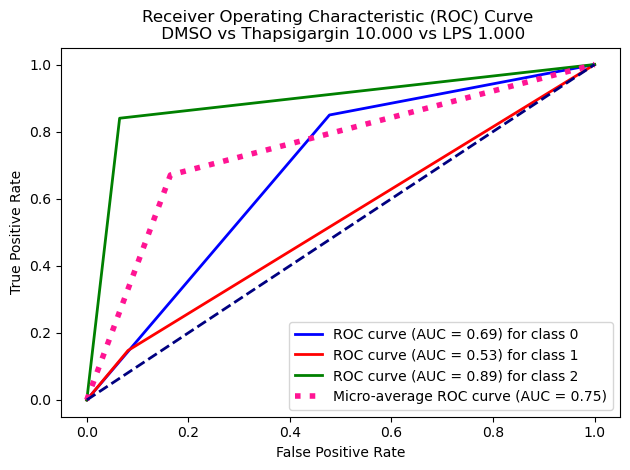

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.68      0.85      0.76     35643
           1       0.43      0.18      0.25     16810
           2       0.77      0.84      0.81     13212

    accuracy                           0.68     65665
   macro avg       0.63      0.62      0.60     65665
weighted avg       0.64      0.68      0.64     65665

Precision for class 0: 0.6819830168705092
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.42718867379370123
Recall for class 1: 0.1759071980963712
Precision for class 2: 0.7734560156141085
Recall for class 2: 0.8398425673630033
3


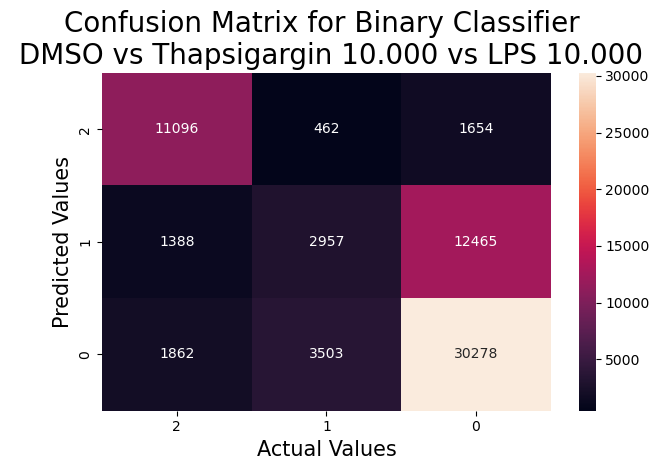

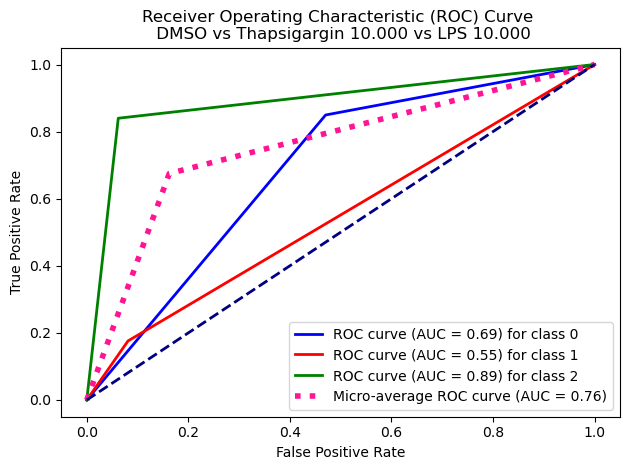

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.92      0.85      0.89     35643
           1       0.79      0.95      0.86     15987
           2       0.86      0.84      0.85     13212

    accuracy                           0.87     64842
   macro avg       0.86      0.88      0.87     64842
weighted avg       0.88      0.87      0.87     64842

Precision for class 0: 0.9240676310809987
Recall for class 0: 0.8494795612041635
Precision for class 1: 0.7924409778568812
Recall for class 1: 0.9468943516607243
Precision for class 2: 0.8553148847606568
Recall for class 2: 0.8398425673630033
3


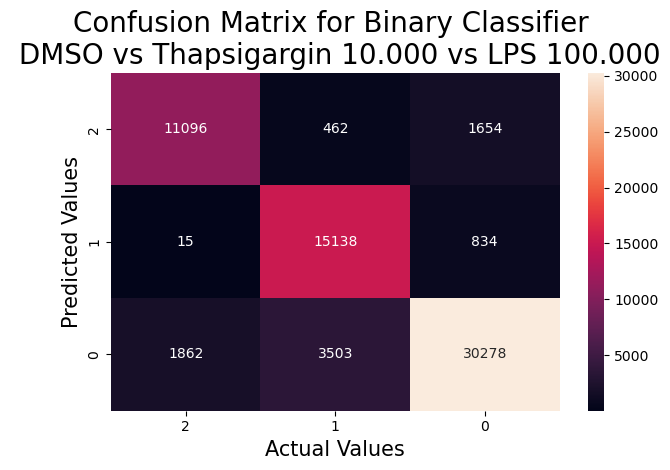

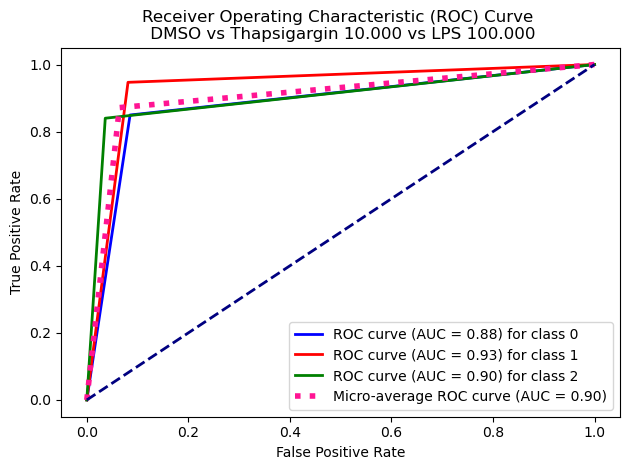

In [7]:
for i, j, k in paired_treatment_list:
    # print(i,j,k)
    test_df = df.query(
        f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{j}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{k}'"
    )
    output_name = (" ").join(
        test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )
    print(output_name)
    # title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])}'
    title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])} vs {(" ").join(output_name.split(" ")[2].split("_")[:2])}'

    test_loop(test_df, output_name, title)